# mini test

In [1]:
# 1.세팅
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import torch
import json

device = "cuda:0" if torch.cuda.is_available() else "cpu"
# torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
torch_dtype = torch.float32
print("------------------ Setup Check ------------------")
print("Using device:", device)
print("Using torch_dtype:", torch_dtype)

# 2.모델 로드
model_id = "microsoft/Florence-2-large"

# print("Loading Florence-2 Large model...")
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    torch_dtype=torch_dtype             # torch.float32
).eval().to(device)

processor = AutoProcessor.from_pretrained(model_id,trust_remote_code=True)

# 3.테스트 데이터 로드
image_path = "./data/test01.JPG"
image = Image.open(image_path).convert("RGB")

/home/dibaeck/miniconda3/envs/proj_311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


------------------ Setup Check ------------------
Using device: cuda:0
Using torch_dtype: torch.float32


In [2]:
def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)

    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3,
        do_sample=False,
        early_stopping=True
    )

    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

In [3]:
task_prompt = "<OCR_WITH_REGION>"
text_input=None

if text_input is None:
        prompt = task_prompt
else:
    prompt = task_prompt + text_input

inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch_dtype)

In [4]:
generated_ids = model.generate(
        input_ids=inputs["input_ids"].cuda(),
        pixel_values=inputs["pixel_values"].cuda(),
        max_new_tokens=4096,
        num_beams=3,
        do_sample=False,
        early_stopping=True
    )
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

print(generated_text)

This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (4096). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


</s><s><s><s>NO.1 SINTER MAIN 에세요 2F<loc_52><loc_48><loc_176><loc_48><loc_176><loc_65><loc_52><loc_65>2<loc_199><loc_27><loc_205><loc_27><loc_205><loc_36><loc_199><loc_36>3<loc_318><loc_27><loc_323><loc_27><loc_323><loc_35><loc_318><loc_35>1.2.0.0 0.0 1.0 2.0<loc_417><loc_48><loc_524><loc_48><loc_524><loc_64><loc_417><loc_64>LOCAL AREA<loc_744><loc_49><loc_796><loc_49><loc_796><loc_63><loc_744><loc_63>1.0-1.1.5.0
2.2 0.5 0.1 0.2 1.5 2.5 1.2 2.1 2.2 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0 34.0 35.0 37.0 38.0 39.0 40.0 41.0 42.0 43.0 44.0 45.0 46.0 47.0 48.0 49.0 50.0 51.0 52.0 53.0 54.0 55.0 56.0 57.0 58.0 59.0 60.0 61.0 62.0 63.0 64.0 65.0 66.0 67.0 68.0 69.0 70.0 71.0 73.0 74.0 77.0 78.0 79.0 80.0 81.0 82.0 83.0 84.0 85.0 86.0 87.0 88.0 89.0 91.0 94.0 95.0 97.0 98.0 99.0 92.0 93.0 04.0 05.0 96.0 07.0 09.0 08.0 01.0 06.0 02.0 03.0 00.0 101.0 103.0 104.0 105.0 106.0 107.0 108.0 10

In [5]:
parsed_answer = processor.post_process_generation(
    	generated_text,
    	task=task_prompt,
    	image_size=(image.width, image.height)
	)

In [6]:
import supervision as sv

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, parsed_answer, resolution_wh=image.size)


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


In [ ]:
# # 26버전
# box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
# label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

# annotated = box_annotator.annotate(image, detections=detections)
# annotated = label_annotator.annotate(annotated, detections=detections)
# sv.plot_image(annotated)

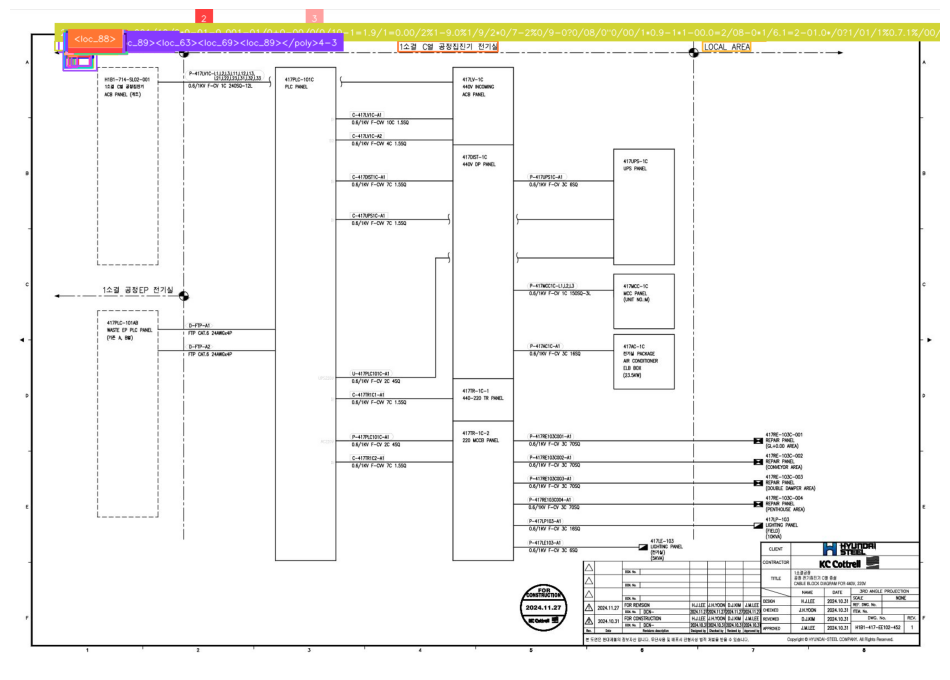

In [10]:
annotated = bounding_box_annotator.annotate(image, detections=detections)
annotated = label_annotator.annotate(annotated, detections=detections)
sv.plot_image(annotated)